In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

In [2]:
train_path = '../datasets/adult_train.csv'
test_path = '../datasets/adult_test.csv'
os.path.exists(train_path) and os.path.exists(test_path)

True

# 1. 数据读取

In [3]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

In [4]:
df_train = pd.read_csv(train_path, names=COLUMNS)
df_test = pd.read_csv(test_path, names=COLUMNS)
df_train.shape, df_test.shape

((32561, 15), (16281, 15))

In [5]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# 2. 数据预处理

数据中，`income_bracket`共有两项：`>50K, <=50K`，一个合理的处理是变为0，1值，在此问题中是**输出值**。

通过一下两种方法都可以看出该项取值情况：

## 2.1 `age_group`和`income_bracket`特征处理

In [6]:
df_train['income_bracket'].value_counts()

 <=50K    24720
 >50K      7841
Name: income_bracket, dtype: int64

In [7]:
np.unique(df_train['income_bracket'].values)

array([' <=50K', ' >50K'], dtype=object)

In [8]:
def process_on_age_and_income(dfs):
    for df in dfs:
        age_groups = [0, 25, 65, 90]
        age_labels = range(len(age_groups) - 1)
        df['income_label'] = (df['income_bracket'].apply(lambda x: '>50K' in x)).astype(np.int)
        df['age_group'] = pd.cut(df['age'], bins=age_groups, labels=age_labels)

In [9]:
process_on_age_and_income([df_train, df_test])

In [10]:
df_train.head(2)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket,income_label,age_group
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0,1
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0,1


## 2.2 确定wide, deep层特征

In [11]:
# wide部分的原始特征及交叉特征
wide_cols = ['workclass', 'education', 'marital_status', 'occupation', \
             'relationship', 'race', 'gender', 'native_country', 'age_group']
x_cols = (['education', 'occupation'], ['native_country', 'occupation'])

# deep部分的特征分为两大类，一类是数值特征(可以直接输入到网络中进行训练)，
# 一类是类别特征(只能在embedding之后才能输入到模型中进行训练）
embedding_cols = ['workclass', 'education', 'marital_status', 'occupation', \
                  'relationship', 'race', 'gender', 'native_country']
numerical_cols = ['age', 'capital_gain', 'capital_loss', 'hours_per_week']

# 选作输出的标签
target = 'income_label'

### 2.3 Wide层特征处理

**注：函数中如果会改变列表元素，需要传入copy，不要直接更改源列表**。这个问题调试了很久。

Wide层特征处理主要是将类别项处理成one-hot表示。

In [12]:
def process_wide_features(df_train, df_test, wide_cols, x_cols, target):
    df_train['IS_TRAIN'] = 1
    df_test['IS_TRAIN'] = 0
    df = pd.concat([df_train, df_test], axis=0)
    
    crossed_columns = []
    for c1, c2 in x_cols:
        col_name = c1 + '_' + c2
        crossed_columns.append(col_name)
        df[col_name] = df[[c1, c2]].apply(lambda x: ' -'.join(x), axis=1)
    wide_cols += crossed_columns
    df = df[wide_cols + [target, 'IS_TRAIN']]
    categorical_columns = df.select_dtypes(include='object').columns
    
    df = pd.get_dummies(df, columns=categorical_columns)
    train = df[df.IS_TRAIN == 1].drop('IS_TRAIN', axis=1)
    test = df[df.IS_TRAIN == 0].drop('IS_TRAIN', axis=1)
    
    ex = list(train.columns)
    ex.remove(target)
    X1 = train[ex].values
    y1 = train[target].values.reshape(-1, 1)
    X2 = test[ex].values
    y2 = test[target].values.reshape(-1, 1)
    return X1, y1, X2, y2

In [13]:
X_train_wide, y_train_wide, X_test_wide, y_test_wide =\
    process_wide_features(df_train, df_test, wide_cols.copy(), x_cols, target)

In [14]:
print('处理后数据形状（train）：', X_train_wide.shape, y_train_wide.shape)
print('处理后数据形状（test）：', X_test_wide.shape, y_test_wide.shape)

处理后数据形状（train）： (32561, 809) (32561, 1)
处理后数据形状（test）： (16281, 809) (16281, 1)


## 2.4 Deep层特征处理

三部分：
1. 数值型数据标准化
2. 类别型数据数值化
3. 构建embedding层

In [15]:
def process_deep_features(df_train, df_test, embedding_cols, numerical_cols,
                          target, embedding_dim=8, embedding_reg=1e-3):
    df_train['IS_TRAIN'] = 1
    df_test['IS_TRAIN'] = 0
    df = pd.concat([df_train, df_test], axis=0)
    
    deep_cols = embedding_cols + numerical_cols
    # 拼接数值特征和embedding特征
    df = df[deep_cols + [target, 'IS_TRAIN']]
    
    # 类别特征编码，设置词汇表保存所有类别编码对应
    vocabulary = {}
    label_encoder = preprocessing.LabelEncoder()
    for feature in embedding_cols:
        df[feature] = label_encoder.fit_transform(df[feature])
        vocabulary[feature] = dict(zip(range(len(label_encoder.classes_)), 
                                         label_encoder.classes_))
    
    # 数值类特征进行标准化
    scaler = preprocessing.StandardScaler()
    df.loc[:, numerical_cols] = pd.DataFrame(scaler.fit_transform(
        df[numerical_cols]), columns=numerical_cols)
    
    input_layer = []
    embedding_layer = []
    for embedding_col in embedding_cols:
        layer_name = embedding_col + '_input'
        input_ = keras.layers.Input(shape=(1, ), name=layer_name)
        embedding = keras.layers.Embedding(
            len(vocabulary[embedding_col].keys()), embedding_dim, 
            embeddings_regularizer=keras.regularizers.l2(embedding_reg))(input_)
        input_layer.append(input_)
        embedding_layer.append(embedding)
        
    for numerical_col in numerical_cols:
        layer_name = numerical_col + '_input'
        input_ = keras.layers.Input(shape=(1, ), name=layer_name)
        input_layer.append(input_)
        embedding_layer.append(keras.layers.Reshape((1, 1))(input_))
    
    # 训练和测试集分离
    train = df[df.IS_TRAIN == 1].drop('IS_TRAIN', axis=1)
    test = df[df.IS_TRAIN == 0].drop('IS_TRAIN', axis=1)
    
    X1 = train[deep_cols].values
    y1 = train[target].values.reshape(-1, 1)
    X2 = test[deep_cols].values
    y2 = test[target].values.reshape(-1, 1)
    return X1, y1, X2, y2, input_layer, embedding_layer, vocabulary

In [16]:
X_train_deep, y_train_deep, X_test_deep, y_test_deep, input_layer, \
    embedding_layer, vocabulary = process_deep_features(
    df_train, df_test, embedding_cols=embedding_cols, 
    numerical_cols=numerical_cols, target=target)

In [17]:
print('处理后数据形状（train）：', X_train_deep.shape, y_train_deep.shape)
print('处理后数据形状（test）：', X_test_deep.shape, y_test_deep.shape)

处理后数据形状（train）： (32561, 12) (32561, 1)
处理后数据形状（test）： (16281, 12) (16281, 1)


In [18]:
print('Embedding层：', embedding_layer, sep='\n')

Embedding层：
[<tf.Tensor 'embedding/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_1/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_2/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_3/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_4/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_5/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_6/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'embedding_7/embedding_lookup/Identity_1:0' shape=(None, 1, 8) dtype=float32>, <tf.Tensor 'reshape/Reshape:0' shape=(None, 1, 1) dtype=float32>, <tf.Tensor 'reshape_1/Reshape:0' shape=(None, 1, 1) dtype=float32>, <tf.Tensor 'reshape_2/Reshape:0' shape=(None, 1, 1) dtype=float32>, <tf.Tensor 'reshape_3/Reshape:0' shape=(None, 1, 1) dtype=float32>]

In [19]:
print('LabelEncoder词汇表：', vocabulary, sep='\n')

LabelEncoder词汇表：
{'workclass': {0: ' ?', 1: ' Federal-gov', 2: ' Local-gov', 3: ' Never-worked', 4: ' Private', 5: ' Self-emp-inc', 6: ' Self-emp-not-inc', 7: ' State-gov', 8: ' Without-pay'}, 'education': {0: ' 10th', 1: ' 11th', 2: ' 12th', 3: ' 1st-4th', 4: ' 5th-6th', 5: ' 7th-8th', 6: ' 9th', 7: ' Assoc-acdm', 8: ' Assoc-voc', 9: ' Bachelors', 10: ' Doctorate', 11: ' HS-grad', 12: ' Masters', 13: ' Preschool', 14: ' Prof-school', 15: ' Some-college'}, 'marital_status': {0: ' Divorced', 1: ' Married-AF-spouse', 2: ' Married-civ-spouse', 3: ' Married-spouse-absent', 4: ' Never-married', 5: ' Separated', 6: ' Widowed'}, 'occupation': {0: ' ?', 1: ' Adm-clerical', 2: ' Armed-Forces', 3: ' Craft-repair', 4: ' Exec-managerial', 5: ' Farming-fishing', 6: ' Handlers-cleaners', 7: ' Machine-op-inspct', 8: ' Other-service', 9: ' Priv-house-serv', 10: ' Prof-specialty', 11: ' Protective-serv', 12: ' Sales', 13: ' Tech-support', 14: ' Transport-moving'}, 'relationship': {0: ' Husband', 1: ' N

# 3. 模型构造

## 3.1 特征拼接

将wide特征和deep特征拼接起来，同时将输入的数据类型变为float32类型。

In [20]:
wide_features_num = X_train_wide.shape[1]
deep_features_num = X_train_deep.shape[1]

In [21]:
wide_features_num, deep_features_num

(809, 12)

In [22]:
X_train = np.concatenate([X_train_wide, X_train_deep], axis=1).astype(np.float32)
y_train = y_train_deep.astype(np.float32)
X_test = np.concatenate([X_test_wide, X_test_deep], axis=1).astype(np.float32)
y_test = y_test_deep.astype(np.float32)

拼接后的形状

In [23]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32561, 821), (32561, 1), (16281, 821), (16281, 1))

## 3.2 搭建模型

In [24]:
def define_model(embedding_layer, input_layer):
    # Deep模型
    d = keras.layers.concatenate(embedding_layer)
    d = keras.layers.Flatten()(d)
    d = keras.layers.Dense(50, activation='relu', 
                           kernel_regularizer=keras.regularizers.l1_l2(l1=0.01,
                                                                       l2=0.01))(d)
    d = keras.layers.Dropout(0.5)(d)
    d = keras.layers.Dense(20, activation='relu')(d)
    d = keras.layers.Dropout(0.5, name='deep')(d)

    # Wide模型
    w = keras.Input(shape=(X_train_wide.shape[1], ), dtype='float32', name='wide')

    wide_and_deep_input = keras.layers.concatenate([w, d])
    wide_and_deep_out = keras.layers.Dense(y_train.shape[1],
                                           activation='sigmoid',
                                           name='Wide_Deep')(wide_and_deep_input)
    model = keras.Model(inputs=[w] + input_layer, outputs=wide_and_deep_out, name='Wide_and_Deep')
    return model

## 3.3 模型编译与训练

In [27]:
model = define_model(embedding_layer, input_layer)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                                              loss='binary_crossentropy',
                                              metrics=['AUC'])
model.fit([X_train_wide.astype(np.float32), 
           np.split(X_train_deep.astype(np.float32), 
                    np.arange(1, 12), axis=1)],
          y_train, epochs=10, batch_size=128)

Epoch 1/10
255/255 [==============================] - 3s 11ms/step - loss: 1.8011 - auc: 0.7786
Epoch 2/10
255/255 [==============================] - 3s 11ms/step - loss: 0.4060 - auc: 0.8783
Epoch 3/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3801 - auc: 0.8887
Epoch 4/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3660 - auc: 0.8946
Epoch 5/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3569 - auc: 0.8978
Epoch 6/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3513 - auc: 0.9002
Epoch 7/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3457 - auc: 0.9028
Epoch 8/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3429 - auc: 0.9039
Epoch 9/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3393 - auc: 0.9052
Epoch 10/10
255/255 [==============================] - 3s 11ms/step - loss: 0.3371 - auc: 0.9063


## 3.4 模型效果评估

In [28]:
model.evaluate([X_test_wide.astype(np.float32),
                np.split(X_test_deep.astype(np.float32),
                         np.arange(1, 12), axis=1)],
               y_test)

509/509 [==============================] - 3s 7ms/step - loss: 0.5114 - auc: 0.8360


[0.5113685727119446, 0.8360229730606079]

## 4. 模型可视化

需要先安装pydot和graphviz。

In [32]:
img_path = '../imgs/wide&deep.png'

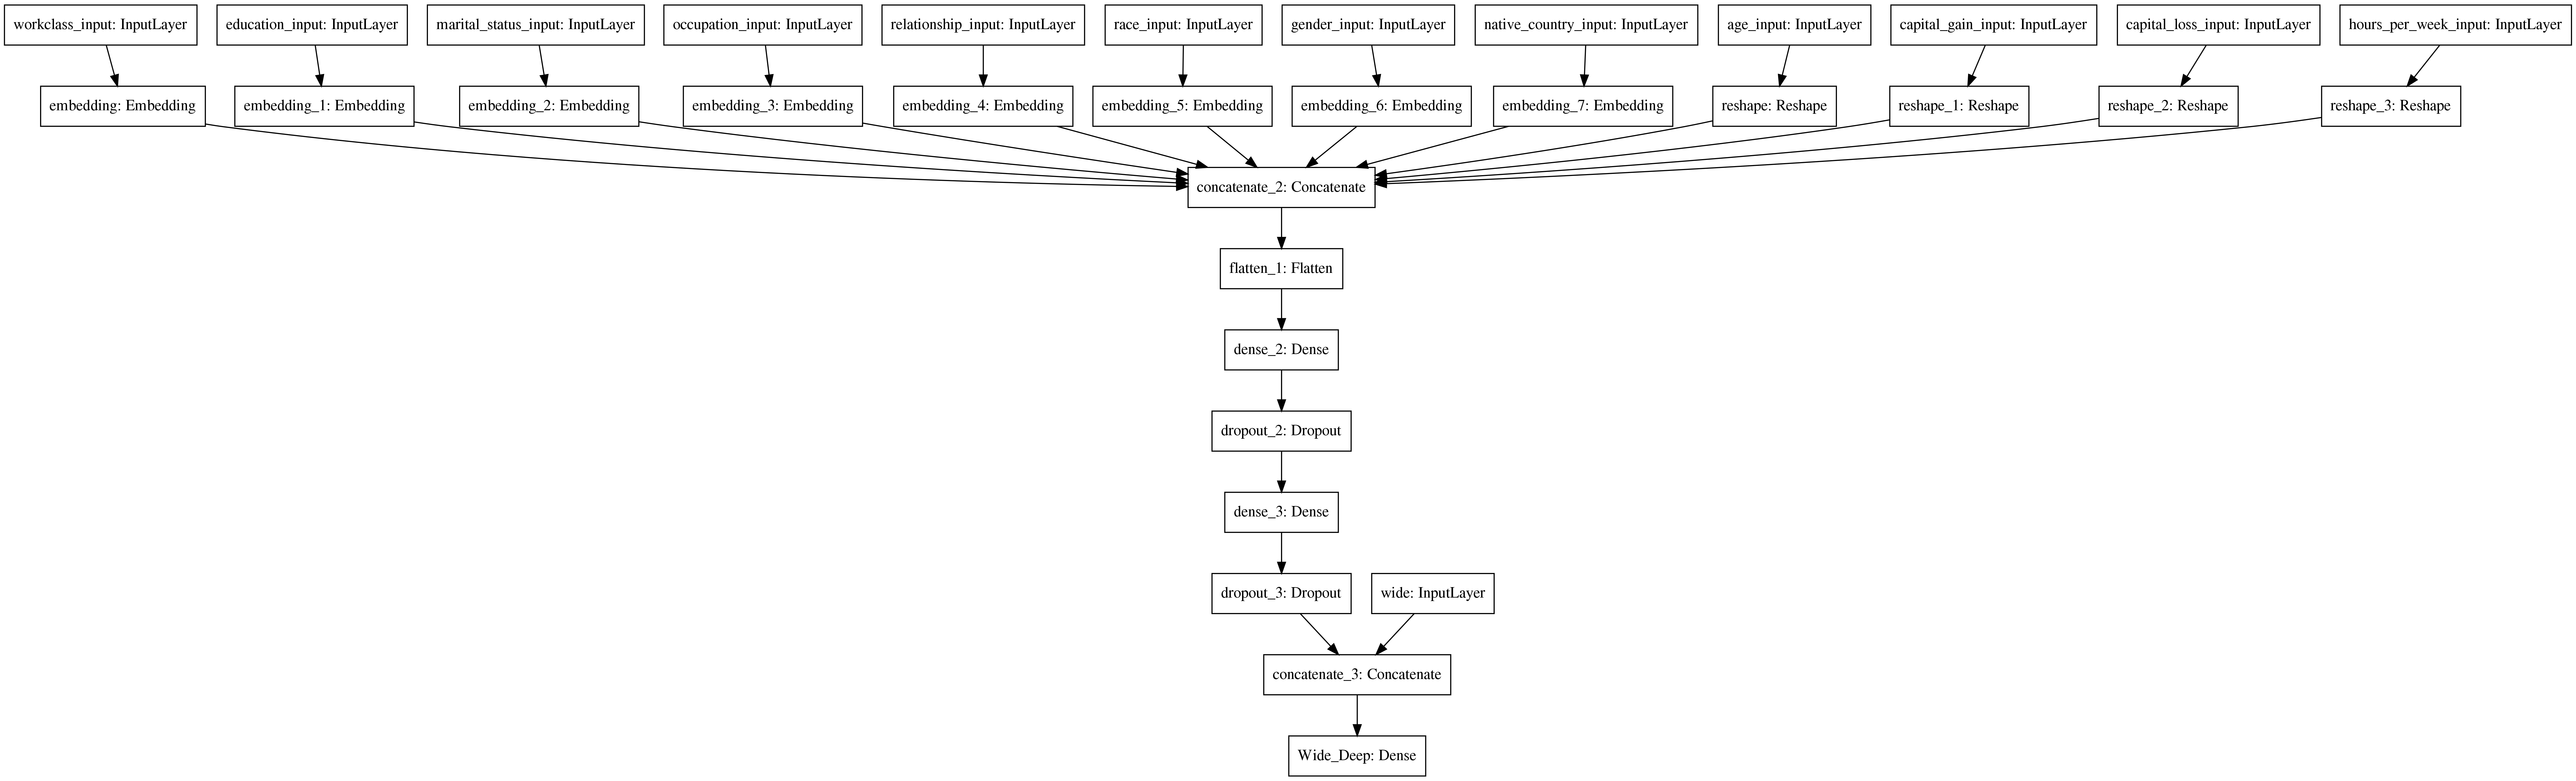

In [34]:
keras.utils.plot_model(model, img_path, dpi=300)